# Heart Segmentation Project

## Introduction
This project focuses on segmenting different parts of the heart using deep learning techniques. We will use a dataset of medical images and train a model to accurately segment regions of interest.

### Objectives
- Segment the right ventricle (RV)
- Segment the myocardium (MYO)
- Segment the left ventricle (LV)

## Dependencies Import and Exploration
This section covers the initial steps of importing every dependency for data manipulation, transformation, visualization, model handling, and other utilities. It also includes a command to mount Google Drive for accessing files in a Google Colab environment.

1. `gc` and `gc.collect()`: Imports the garbage collection module and calls the `collect` method to free up memory.
2. `random`: Provides functions for generating random numbers and making random selections.
3. `torchvision.transforms as t`: Imports the `transforms` module from `torchvision`, which provides image transformation functions.
4. `IPython.display import Image as IPImage`: Imports the `Image` class from `IPython.display` for displaying images in Jupyter notebooks.
5. `torch`: The main library for PyTorch, used for building and training neural networks.
6. `sys`: Provides access to system-specific parameters and functions.
7. `os`: Provides functions for interacting with the operating system.
8. `pandas as pd`: Imports pandas, a data manipulation and analysis library.
9. `matplotlib.pyplot as plt`: Imports the plotting library for creating static, animated, and interactive visualizations.
10. `numpy as np`: Imports NumPy, a library for numerical operations on arrays.
11. `torch.nn as nn`: Imports the neural network module from PyTorch.
12. `nibabel as nib`: Imports nibabel for reading and writing medical image formats.
13. `torch.nn.functional as F`: Imports functional operations for neural networks from PyTorch.
14. `pickle`: Provides functions for serializing and deserializing Python objects.
15. `torch.utils.data import Dataset, DataLoader, random_split`: Imports data handling classes from PyTorch.
16. `PIL import Image`: Imports the Python Imaging Library (PIL) for image processing.
17. `imageio`: Provides functions for reading and writing images.
18. `time`: Provides functions for time-related operations.
19. `torchvision.models as models`: Imports pre-trained models from `torchvision`.
20. `cv2`: Imports OpenCV for computer vision tasks.
21. `statistics import mode`: Imports the mode function for statistical operations.
22. `google.colab import drive` and `drive.mount('/content/gdrive')`: Imports the Google Drive module from Google Colab and mounts the Google Drive for accessing files.

In [ ]:
!pip install nibabel

In [ ]:
import gc
gc.collect()
import random
from torchvision.transforms import v2 as t
from IPython.display import Image as IPImage
import random
import torch
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import nibabel as nib
import torch.nn.functional as F
from torchvision.transforms import v2 as t
import random
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import imageio
import time
from IPython.display import Image as IPImage
import gc
import torchvision.models as models
import cv2
from statistics import mode
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## import numpy as np
sys.path.append('/content/gdrive/MyDrive/finalproject-ruangguru')
import functs as m
from loss_function import Adaptive_tvMF_DiceLoss
from unet_model import U_Net
# device = device = xm.xla_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count())
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

cuda 1


## Data Preprocessing
This section involves preparing the data and perform transformations on each of the image from the training data for model building.

#### <strong> Joint Transformations </strong>

These transformations are applied to both images and their corresponding masks. This ensures that the spatial relationship between images and masks is maintained.

1. `t.RandomHorizontalFlip(0.5)`: This flips the image and mask horizontally with a 50% chance.
2. `t.RandomVerticalFlip(0.5)`: This flips the image and mask vertically with a 50% chance.
3. (Commented out) `t.RandomAffine`: Applies affine transformations such as rotation, translation, scaling, and shearing.
4. (Commented out) `t.RandomPerspective`: Applies a random perspective transformation with a given distortion scale and probability.

#### <strong> Image-Specific Transformations </strong>

These transformations are applied only to the images, not the masks.

1. `t.GaussianBlur(3)`: Applies a Gaussian blur to the image with a kernel size of 3.
2. `t.RandomEqualize(0.5)`: Equalizes the histogram of the image with a 50% chance.
3. `t.RandomAutocontrast(0.5)`: Maximizes the image contrast with a 50% chance.

#### <strong> Dataset Initialization </strong>

The `ACDC_2D_Dataset` is initialized with the paths to a CSV file containing image metadata and a database directory. The joint and image-specific transformations are passed as arguments.

#### <strong> Image and Mask Display </strong>

A random image and its corresponding mask are selected from the dataset and displayed using the `show_img` function from the custom module `m`.

Image torch.Size([128, 128]) Mask torch.Size([128, 128])


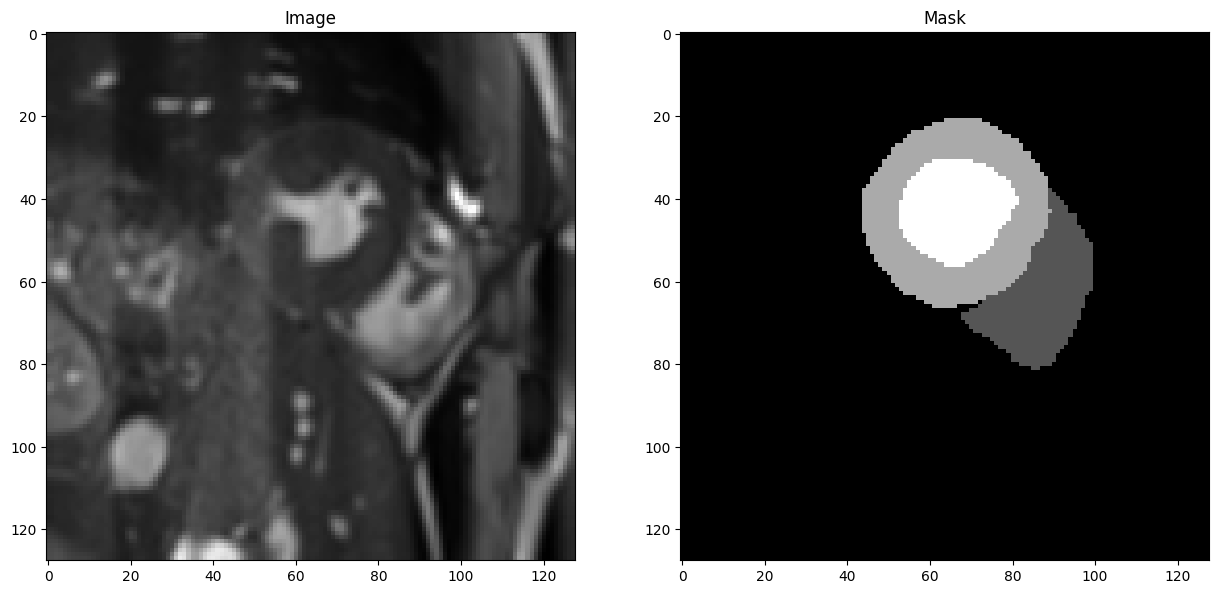

In [ ]:
joint_transform = t.Compose([
    t.RandomHorizontalFlip(0.5),
    t.RandomVerticalFlip(0.5),
#     t.RandomAffine(
#         degrees = (-45, 45),
#         translate = (0.2, 0.2),
#         scale = (0.8,1.2),
#         shear = (-15, 15, -15, 15)
#     ),
#     t.RandomPerspective(
#         distortion_scale = 0.5,
#         p = 0.3,
#     ),
])

image_transform = t.Compose([
    t.GaussianBlur(3),
    t.RandomEqualize(0.5),
    t.RandomAutocontrast(0.5)
])

data = m.ACDC_2D_Dataset(
    "/content/gdrive/MyDrive/finalproject-ruangguru/train.csv",
    "/content/gdrive/MyDrive/finalproject-ruangguru/ACDC",
    joint_transform = joint_transform,
    image_transform = image_transform
)

image, mask = data[random.randint(0,len(data)-1)]
m.show_img(image, mask)

## Model Building and Training

This section of the code defines and trains an autoencoder model using PyTorch. It specifies the model architecture, optimizer, loss function, metrics, and training parameters.

1. **Model Definition**
   - `model = m.TrainedAutoencoder('densenet121', 4)`: Initializes a custom-trained autoencoder model based on the 'densenet121' architecture with 4 output channels.

2. **Optimizer**
   - `optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)`: Sets up the Adam optimizer with a learning rate of 0.0005 and a weight decay of 0.0001.

3. **Loss Function**
   - `loss = m.CustomLoss(weights=[1.0, 0.2, 0.2])`: Initializes a custom loss function with specified weights for different components.

4. **Metrics**
   - `metric = {'RV Dice': m.ClassDice(channel=1), 'MYO Dice': m.ClassDice(channel=2), 'LV Dice': m.ClassDice(channel=3)}`: Defines metrics for evaluation, specifically Dice coefficients for three different classes (RV, MYO, LV).

5. **Training Configuration**
   - `train_data = m.train(data, model, loss, optim, METRIC=metric, DEVICE=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), BATCH_SIZE=128, EPOCHS=350, SAMPLE_IMAGE=image.unsqueeze(0), SAVE_LOC="/content/gdrive/MyDrive/Colab Notebooks/TRYHARD/real_shit_4/results3")`: Trains the model with the specified parameters:
     - `data`: The dataset used for training.
     - `model`: The autoencoder model to be trained.
     - `loss`: The loss function.
     - `optim`: The optimizer.
     - `METRIC`: The evaluation metrics.
     - `DEVICE`: The device to run the training on (GPU if available, otherwise CPU).
     - `BATCH_SIZE`: The batch size for training (128).
     - `EPOCHS`: The number of training epochs (500).
     - `SAMPLE_IMAGE`: A sample image for monitoring training progress.
     - `SAVE_LOC`: The location to save the training results.

In [ ]:
model = m.TrainedAutoencoder('densenet121',4)
optim = torch.optim.Adam(model.parameters(), lr= 0.0005, weight_decay = 0.0001)
loss = m.CustomLoss(weights = [1.0, 0.2, 0.2])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 138MB/s]


In [ ]:
metric = {'RV Dice': m.ClassDice(channel = 1), 'MYO Dice': m.ClassDice(channel = 2), 'LV Dice': m.ClassDice(channel=3)}
train_data = m.train(
    data,
    model,
    loss,
    optim,
    METRIC=metric,
    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    BATCH_SIZE = 128,
    EPOCHS = 500,
    SAMPLE_IMAGE = image.unsqueeze(0),
    SAVE_LOC="/content/gdrive/MyDrive/finalproject-ruangguru/result1",
    SEED = 30
)

Epoch: 1
Train Loss: 0.6361723940 RV Dice: 0.0611350052 MYO Dice: 0.0725134239 LV Dice: 0.0623007827 
Validation Loss: 0.6459383667 Validation RV Dice: 0.0588917248 Validation MYO Dice: 0.0712048262 Validation LV Dice: 0.0609767884 
Time Elapsed: 378.92888283729553s Time Left: 189085.51253581047s
Epoch: 2
Train Loss: 0.6250812759 RV Dice: 0.0574394576 MYO Dice: 0.0847709030 LV Dice: 0.0754804760 
Validation Loss: 0.6464577913 Validation RV Dice: 0.0582315102 Validation MYO Dice: 0.0710571259 Validation LV Dice: 0.0587580130 
Time Elapsed: 100.24703860282898s Time Left: 49923.02522420883s
Epoch: 3
Train Loss: 0.6132456114 RV Dice: 0.0583096109 MYO Dice: 0.1026280150 LV Dice: 0.0757250488 
Validation Loss: 0.6414658129 Validation RV Dice: 0.0508153364 Validation MYO Dice: 0.0781416297 Validation LV Dice: 0.0500910431 
Time Elapsed: 99.73802661895752s Time Left: 49569.79922962189s
Epoch: 4
Train Loss: 0.5982819349 RV Dice: 0.0580589324 MYO Dice: 0.1386084408 LV Dice: 0.0587158613 
Validat

In [ ]:
# loss class, model class

In [ ]:
from google.colab import runtime
runtime.unassign()